In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import pickle
#import statistics as stats
from collections import Counter
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import MaxAbsScaler
#from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
from imblearn.metrics import geometric_mean_score
#from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from deslib.static import Oracle
import oracle # 
import sgh
from rlo import * #rlo.py - Random Linear Oracle implementation based on Kuncheva's book. 


In [27]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')

### Loading data

#### First let's build a function to convert KEEL data to a regular CSV (remove annotations before data):

In [28]:
def keel2csv(file):
    ''' Reads a KEEL .dat file, converts it into a regular CSV data file 
    that contains a header line. The output .csv file is written to the same 
    dir as the original .dat file. This function also returns a dict 
    {'numeric':[], 'nominal':[]} containg two lists, one for the numeric 
    attributes and the other for the nominal atributes.'''
    filename = file.name
    # Let's read the attribute types (useful for preprocessing) and also the 
    # column names from the @annotations, inclunding the target (class) column:
    has_inputs = has_outputs = False
    numeric_atts = []
    nominal_atts = []
    for line in file:
        if '@attribute' in line:
            if (' real' in line) or (' integer' in line):
                numeric_atts.append(line.split(' ')[1])
            elif '{' in line:
                nominal_atts.append(line.split(' ')[1])
        if line.startswith('@inputs'):
            att_names = line[8:-1].replace(' ', '')
            has_inputs = True
        elif line.startswith('@input'):
            att_names = line[7:-1].replace(' ', '')
            has_inputs = True
        elif line.startswith('@outputs') or line.startswith('@output'):
            class_name = line[9:-1]
            has_outputs = True
            break
        elif line.startswith('@output'):
            class_name = line[8:-1]
            has_outputs = True
            break
    if (not has_inputs) or (not has_outputs):
        print('File ', filename, 'missing annotations?' )

    columns = att_names + ',' + class_name

    #Then, lets remove the annotations and save the column names and data into a csv file:
    lines = file.readlines() 
    file.close()
    new_file = open(filename[:-4]+'.csv','w')
    new_file.write(columns+'\n')
    for line in lines:
        if not line.startswith('@'):
            new_file.write(line)
    new_file.close()    
    return {'numeric':numeric_atts, 'nominal':nominal_atts}

#### Now, we need to run through the files and execute the keel2csv function for each KEEL dat file:

In [29]:
ds_names = ['ecoli3', 'segment0', 'vehicle2', 'yeast3','glass6']
rootdir = '/Users/ailtonrodrigues/Desktop/Doctor CIN/data'
# Link para os datasets: https://sci2s.ugr.es/keel/datasets.php

In [30]:
# Converting KEEL .dat files to CSV:
att_types = {} #This dictionary will have each dataset name as key and will hold the attribute types.
for name in ds_names:
    for fold in range(1,6):
        full_path = rootdir+'/'+name+'-5-fold/'+name+'-5-'+str(fold)+'tra.dat' 
        f = open(full_path, 'r')
        att_types[name] = keel2csv(f)
        f.close()
        full_path = rootdir+'/'+name+'-5-fold/'+name+'-5-'+str(fold)+'tst.dat' 
        f = open(full_path, 'r')
        keel2csv(f)
        f.close()

#### Ok, now that we finally have all the data in CSV format, lets load them:

In [31]:
# I will create a dict structure such that I can access train fold 1 from 
# dataset wisconsin as datasets['wisconsin']['train'][0]

datasets = {}
for name in ds_names:
    datasets[name] = {}
    datasets[name]['train'] = []
    datasets[name]['test'] = []
    for fold in range(1,6):
        csv_filename = rootdir+'/'+name+'-5-fold/'+name+'-5-'+str(fold)+'tra.csv'
        df_train = pd.read_csv(csv_filename, encoding='utf8', engine='python', sep=',', 
                     header=0, error_bad_lines=False)
        csv_filename = rootdir+'/'+name+'-5-fold/'+name+'-5-'+str(fold)+'tst.csv'
        df_test = pd.read_csv(csv_filename, encoding='utf8', engine='python', sep=',', 
                     header=0, error_bad_lines=False)
        datasets[name]['train'].append(df_train)
        datasets[name]['test'].append(df_test)


In [32]:
datasets['vehicle2']['train'][0]

,Compactness,Circularity,Distance_circularity,Radius_ratio,Praxis_aspect_ratio,Max_length_aspect_ratio,Scatter_ratio,Elongatedness,Praxis_rectangular,Length_rectangular,Major_variance,Minor_variance,Gyration_radius,Major_skewness,Minor_skewness,Minor_kurtosis,Major_kurtosis,Hollows_ratio,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,negative
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,negative
2,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,negative
3,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,positive
4,107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,93,34,66,140,56,7,130,51,18,120,151,251,114,62,5,29,201,207,negative
672,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,negative
673,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,negative
674,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,negative


## Pre-processing

### Cleaning strings

In [33]:
# Cleaning (stripping) strings within dataframe and also changing class labels to 1 and 0.
for name in ds_names:
    for s in ['train', 'test']:
        for fold in range(5):
            df = datasets[name][s][fold]
            df_obj = df.select_dtypes(['object'])
            df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
            df['Class'] = df['Class'].replace(['positive', 'negative'],[1,0])
                

### Scaling

Applying the Standard Scaler to the numeric attributes:

In [34]:
ss = StandardScaler()

# for name in ds_names:
#     for s in ['train', 'test']:
#         for fold in range(5):
#             datasets[name][s][fold][att_types[name]['numeric']] = ss.fit_transform(datasets[name][s][fold][att_types[name]['numeric']])

for name in ds_names:
    for fold in range(5):
        datasets[name]['train'][fold][att_types[name]['numeric']] = ss.fit_transform(datasets[name]['train'][fold][att_types[name]['numeric']])
        datasets[name]['test'][fold][att_types[name]['numeric']] = ss.transform(datasets[name]['test'][fold][att_types[name]['numeric']])


### One-hot encoding

Here we must apply this encoding method to the nominal attributes in order to allow them to be managed by the classification algorithms.

In [35]:
for name in ds_names:
    for s in ['train', 'test']:
        for fold in range(5):
            for att in att_types[name]['nominal'][:-1]: #For each nominal attribute, except the target one (last one)
                att_encoded = pd.get_dummies(datasets[name][s][fold][att], prefix = att)
                datasets[name][s][fold] = datasets[name][s][fold].drop([att], axis = 1)
                datasets[name][s][fold] = pd.concat([att_encoded, datasets[name][s][fold]], axis = 1)

### Dealing with missing values

Applying a Simple Imputer to the numeric attributes.

In [36]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
for name in ds_names:
    for s in ['train', 'test']:
        for fold in range(5):
            datasets[name][s][fold][att_types[name]['numeric']] = imp_mean.fit_transform(datasets[name][s][fold][att_types[name]['numeric']])

# Exercício 1

1.	Selecione 
    a.	cinco bases de dados públicas (já com 5-folds extraídas da página:https://sci2s.ugr.es/keel/imbalanced.php ) com características diferentes.
        ecoli3', 'segment0', 'vehicle2', 'yeast3','page-blocks0'
        
    
    b. Para cada base calcule o Oracle no conjunto de teste para: 
        i.	Bagging
        ii.	Adaboost
        iii.Random Subespace (50%)
        iv.	Random Oracles

    - Variando o número de classificadores-base {10, 20,...100}
    - Use o perceptron como classificador-base e divida os fold usando 5-fold cross-validation

## Bulding and running the ensembles of classifiers

In [37]:
## Creating a results.csv file with a header row:
results_file = open('./results.csv', 'a')
header = 'Dataset Name,model,n_estimators,accuracy,acc_std_dev,f1,f1_std_dev,g_mean,g_mean_std_dev,oracle_mean,oracle_std_dev\n'
results_file.write(header)
results_file.close()

### First let's run a single-model (perceptron) classifier to stablish a baseline.

In [38]:
results_file = open('./results.csv', 'a')

model_percep = Perceptron(random_state=0)
for name in ds_names:
    acc_folds = []
    f1_folds = []
    g_mean_folds = []
    for fold in range(5):
        # Gather training data:
        ds_train = datasets[name]['train'][fold]
        target_att = ds_train.columns.tolist()[-1]
        X_train = ds_train.drop(labels=target_att, axis = 1)
        y_train = ds_train[target_att]

        # Gather test data:
        ds_test = datasets[name]['test'][fold]
        X_test = ds_test.drop(labels=target_att, axis = 1)
        y_test = ds_test[target_att]

        # Train model with the training data, we need y_score for calculating ROC-AUC
        y_score = model_percep.fit(X_train, y_train).decision_function(X_test)
        
        # Test model:
        y_pred = model_percep.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        g_mean = geometric_mean_score(y_test, y_pred)
        
        # Store metrics for this fold
        acc_folds.append(acc)
        f1_folds.append(f1)
        g_mean_folds.append(g_mean)
        
        #cnf_matrix = confusion_matrix(y_test, y_pred)
        #print('Dataset %s, Fold %d, Accuracy: %.2f, F1-score: %.2f, ROC-AUC %.2f, G-Mean %.2f' % (name, fold, acc, f1, roc_auc, g_mean))
        #print(cnf_matrix)
    
    # Calculate means and std devs for each metric 
    acc_mean = str(np.average(acc_folds))
    acc_std_dev = str(np.std(acc_folds))
    f1_mean = str(np.average(f1_folds))
    f1_std_dev = str(np.std(f1_folds))
    g_mean_mean = str(np.average(g_mean_folds))
    g_mean_std_dev = str(np.std(g_mean_folds))
    results_file.write(name+',Perceptron,1,'+acc_mean+','+acc_std_dev+','+f1_mean+','+f1_std_dev+','
                       +g_mean_mean+','+g_mean_std_dev+', ,\n')

results_file.close()

### Creating a generic function to run the ensembles with 5-fold cross val and save results:

In [39]:
def run_model(meta_model_name, meta_model, results_file, save_models):
    for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        print('Running', meta_model_name, 'with %d base estimators'%n)
        meta_model.n_estimators=n
        for name in ds_names:
            acc_folds = []
            f1_folds = []
            g_mean_folds = []
            oracle_scores = []
            for fold in range(5):
                ## Gather training data:
                ds_train = datasets[name]['train'][fold]
                target_att = ds_train.columns.tolist()[-1]
                X_train = ds_train.drop(labels=target_att, axis = 1)
                y_train = ds_train[target_att]

                ## Gather test data:
                ds_test = datasets[name]['test'][fold]
                X_test = ds_test.drop(labels=target_att, axis = 1)
                y_test = ds_test[target_att]

                ## Train model with the training data:
                meta_model.fit(X_train,y_train)
                
                ## Test model:
                y_pred = meta_model.predict(X_test)
                
                if save_models:
                    ## Save the model object to a file for later use
                    filename = 'saved_models/'+meta_model_name+'_n'+str(n)+'_dataset_'+name+'_fold_'+str(fold)+'.sav'
                    pickle.dump(meta_model, open(filename, 'wb'))
                    ## Later load model with: loaded_model = pickle.load(open(filename, 'rb'))

                ## Calculate metrics:
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, pos_label=1)
                g_mean = geometric_mean_score(y_test, y_pred)

                ## Store metrics for this fold:
                acc_folds.append(acc)
                f1_folds.append(f1)
                g_mean_folds.append(g_mean)
                #cnf_matrix = confusion_matrix(y_test, y_pred)
                #print(cnf_matrix)

                oracle = Oracle(meta_model).fit(X_train, y_train)
                oracle_score = oracle.score(X_test, y_test)
                oracle_scores.append(oracle_score)

            ## Calculate means and std devs for each metric 
            acc_mean = str(np.average(acc_folds))
            acc_std_dev = str(np.std(acc_folds))
            f1_mean = str(np.average(f1_folds))
            f1_std_dev = str(np.std(f1_folds))
            g_mean_mean = str(np.average(g_mean_folds))
            g_mean_std_dev = str(np.std(g_mean_folds))
            oracle_mean = str(np.average(oracle_scores))
            oracle_std_dev = str(np.std(oracle_scores))
            results_file.write(name+','+meta_model_name+','+str(n)+','+acc_mean+','+acc_std_dev+','+f1_mean+','
                               +f1_std_dev+','+g_mean_mean+','+g_mean_std_dev+','+oracle_mean+','+oracle_std_dev+'\n')

### Bagging

In [40]:
results_file = open('./results.csv', 'a')

#base_model = CalibratedClassifierCV(Perceptron(random_state=0))
base_model = Perceptron(random_state=0)
meta_model = BaggingClassifier(base_estimator=base_model, random_state=0, bootstrap=True,
                                bootstrap_features=False, max_features=1.0, n_jobs=-1)            
run_model('Bagging',meta_model, results_file, save_models=True)           
results_file.close()

Running Bagging with 10 base estimators
Running Bagging with 20 base estimators
Running Bagging with 30 base estimators
Running Bagging with 40 base estimators
Running Bagging with 50 base estimators
Running Bagging with 60 base estimators
Running Bagging with 70 base estimators
Running Bagging with 80 base estimators
Running Bagging with 90 base estimators
Running Bagging with 100 base estimators


### AdaBoost

In [41]:
results_file = open('./results.csv', 'a')

#base_model = CalibratedClassifierCV(Perceptron(random_state=0))
base_model = Perceptron(random_state=0)
meta_model = AdaBoostClassifier(base_estimator=base_model,
                                algorithm='SAMME', random_state=0)           
run_model('AdaBoost',meta_model, results_file, save_models=True)           
results_file.close()

Running AdaBoost with 10 base estimators
Running AdaBoost with 20 base estimators
Running AdaBoost with 30 base estimators
Running AdaBoost with 40 base estimators
Running AdaBoost with 50 base estimators
Running AdaBoost with 60 base estimators
Running AdaBoost with 70 base estimators
Running AdaBoost with 80 base estimators
Running AdaBoost with 90 base estimators
Running AdaBoost with 100 base estimators


### Random Linear Oracles

In [42]:
def run_model_rlo(meta_model_name, meta_model, results_file, save_models):
    for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        print('Running', meta_model_name, 'with %d base estimators'%n)
        meta_model = RLO(base_estimator=Perceptron(random_state=0))
        meta_model.n_estimators=n
        #for name in ['vowel0']:
        for name in ds_names:
            acc_folds = []
            f1_folds = []
            g_mean_folds = []
            oracle_scores = []
            for fold in range(5):
                ## Gather training data:
                ds_train = datasets[name]['train'][fold]
                target_att = ds_train.columns.tolist()[-1]
                X_train = ds_train.drop(labels=target_att, axis = 1).to_numpy()
                y_train = ds_train[target_att].to_numpy()

                ## Gather test data:
                ds_test = datasets[name]['test'][fold]
                X_test = ds_test.drop(labels=target_att, axis = 1).to_numpy()
                y_test = ds_test[target_att].to_numpy()
                while True:
                    try:
                        ## Train model with the training data:
                        meta_model.fit(X_train,y_train)
                        ## Test model:
                        #y_pred = meta_model.predict(X_test)
                        predictions, pred_ens, erro = meta_model.predict(X_test, y_test)
                        break
                    except:
                        continue
                    break
                
                if save_models:
                    ## Save the model object to a file for later use
                    filename = 'saved_models/'+meta_model_name+'_n'+str(n)+'_dataset_'+name+'_fold_'+str(fold)+'.sav'
                    pickle.dump(meta_model, open(filename, 'wb'))
                    ## Later load model with: loaded_model = pickle.load(open(filename, 'rb'))

                y_pred = pred_ens.T.ravel()
                ## Calculate metrics:
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, pos_label=1)
                g_mean = geometric_mean_score(y_test, y_pred)

                ## Store metrics for this fold:
                acc_folds.append(acc)
                f1_folds.append(f1)
                g_mean_folds.append(g_mean)
                #cnf_matrix = confusion_matrix(y_test, y_pred)
                #print(cnf_matrix)

                oracle_score = meta_model.Oracle_score(X_test, y_test)
                oracle_scores.append(oracle_score)

            ## Calculate means and std devs for each metric 
            acc_mean = str(np.average(acc_folds))
            acc_std_dev = str(np.std(acc_folds))
            f1_mean = str(np.average(f1_folds))
            f1_std_dev = str(np.std(f1_folds))
            g_mean_mean = str(np.average(g_mean_folds))
            g_mean_std_dev = str(np.std(g_mean_folds))
            oracle_mean = str(np.average(oracle_scores))
            oracle_std_dev = str(np.std(oracle_scores))
            results_file.write(name+','+meta_model_name+','+str(n)+','+acc_mean+','+acc_std_dev+','+f1_mean+','
                               +f1_std_dev+','+g_mean_mean+','+g_mean_std_dev+','+oracle_mean+','+oracle_std_dev+'\n')


In [43]:
results_file = open('./results.csv', 'a')

#base_model = CalibratedClassifierCV(Perceptron(random_state=0))
base_model = Perceptron(random_state=0)
meta_model = RLO(base_estimator=base_model)


run_model_rlo('RLO',meta_model, results_file, save_models=True)           
results_file.close()

Running RLO with 10 base estimators
Running RLO with 20 base estimators
Running RLO with 30 base estimators
Running RLO with 40 base estimators
Running RLO with 50 base estimators
Running RLO with 60 base estimators
Running RLO with 70 base estimators
Running RLO with 80 base estimators
Running RLO with 90 base estimators
Running RLO with 100 base estimators


### Random Subspaces

In [44]:
def run_model_rs(meta_model_name, meta_model, results_file, save_models):
    for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        print('Running', meta_model_name, 'with %d base estimators'%n)
        meta_model.n_estimators=n
        for name in ds_names:
            acc_folds = []
            f1_folds = []
            g_mean_folds = []
            oracle_scores = []
            for fold in range(5):
                ## Gather training data:
                ds_train = datasets[name]['train'][fold]
                target_att = ds_train.columns.tolist()[-1]
                X_train = ds_train.drop(labels=target_att, axis = 1)
                y_train = ds_train[target_att]

                ## Gather test data:
                ds_test = datasets[name]['test'][fold]
                X_test = ds_test.drop(labels=target_att, axis = 1)
                y_test = ds_test[target_att]

                ## Train model with the training data:
                meta_model.fit(X_train,y_train)

                if save_models:
                    ## Save the model object to a file for later use
                    filename = 'saved_models/'+meta_model_name+'_n'+str(n)+'_dataset_'+name+'_fold_'+str(fold)+'.sav'
                    pickle.dump(meta_model, open(filename, 'wb'))
                    ## Later load model with: loaded_model = pickle.load(open(filename, 'rb'))
                    
                ## Test model:
                y_pred = meta_model.predict(X_test)
                
                ## Calculate metrics:
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, pos_label=1)
                g_mean = geometric_mean_score(y_test, y_pred)

                ## Store metrics for this fold:
                acc_folds.append(acc)
                f1_folds.append(f1)
                g_mean_folds.append(g_mean)
                #cnf_matrix = confusion_matrix(y_test, y_pred)
                #print(cnf_matrix)

                base_models = meta_model.estimators_
                base_models_feats = meta_model.estimators_features_

                base_models_preds = []
                for i in range(len(base_models)):
                    #selecting only the columns used for the ith base model.
                    X_test_subspace = X_test.iloc[:,base_models_feats[i]] 
                    y_pred = base_models[i].predict(X_test_subspace)
                    base_models_preds.append(y_pred)

                oracle_hits = []
                for i in range(len(y_test)):
                    oracle_hit = 0
                    for j in range(len(base_models_preds)):
                        if base_models_preds[j][i] == y_test[i]:
                            oracle_hit = 1
                            break
                    oracle_hits.append(oracle_hit)

                oracle_score = np.sum(oracle_hits)/len(oracle_hits)
                oracle_scores.append(oracle_score)

            ## Calculate means and std devs for each metric 
            acc_mean = str(np.average(acc_folds))
            acc_std_dev = str(np.std(acc_folds))
            f1_mean = str(np.average(f1_folds))
            f1_std_dev = str(np.std(f1_folds))
            g_mean_mean = str(np.average(g_mean_folds))
            g_mean_std_dev = str(np.std(g_mean_folds))
            oracle_mean = str(np.average(oracle_scores))
            oracle_std_dev = str(np.std(oracle_scores))
            results_file.write(name+','+meta_model_name+','+str(n)+','+acc_mean+','+acc_std_dev+','+f1_mean+','
                               +f1_std_dev+','+g_mean_mean+','+g_mean_std_dev+','+oracle_mean+','+oracle_std_dev+'\n')


In [45]:
results_file = open('./results.csv', 'a')

#base_model = CalibratedClassifierCV(Perceptron(random_state=0))
base_model = Perceptron(random_state=0)
meta_model = BaggingClassifier(base_estimator=base_model, n_jobs=-1,
                                random_state=0, bootstrap=False,
                                bootstrap_features=False, max_features=0.5) 
#These three last parameters in the above class constructor call make it behave as the Random Subspace algoritm.

run_model_rs('RandomSubspaces',meta_model, results_file, save_models=True)           
results_file.close()

Running RandomSubspaces with 10 base estimators
Running RandomSubspaces with 20 base estimators
Running RandomSubspaces with 30 base estimators
Running RandomSubspaces with 40 base estimators
Running RandomSubspaces with 50 base estimators
Running RandomSubspaces with 60 base estimators
Running RandomSubspaces with 70 base estimators
Running RandomSubspaces with 80 base estimators
Running RandomSubspaces with 90 base estimators
Running RandomSubspaces with 100 base estimators


### Analysing the results

In [46]:
# First, let's load the results.csv file into a dataframe:
results_df = pd.read_csv('results.csv', header='infer', index_col=False)

In [47]:
results_df.head(12)

,Dataset Name,model,n_estimators,accuracy,acc_std_dev,f1,f1_std_dev,g_mean,g_mean_std_dev,oracle_mean,oracle_std_dev
0,ecoli3,Perceptron,1,0.910579,0.028528,0.525312,0.282078,0.674691,0.356176,,NaN
1,segment0,Perceptron,1,0.993935,0.003183,0.978430,0.011671,0.984899,0.014319,,NaN
2,vehicle2,Perceptron,1,0.935030,0.036744,0.872521,0.076002,0.913713,0.060763,,NaN
3,yeast3,Perceptron,1,0.923860,0.015122,0.657619,0.092038,0.803888,0.089416,,NaN
4,glass6,Perceptron,1,0.934551,0.053874,0.758974,0.182286,0.846550,0.116719,,NaN
5,ecoli3,Bagging,10,0.919535,0.020479,0.562976,0.175241,0.701389,0.166062,0.9910447761194028,0.011940
6,segment0,Bagging,10,0.997399,0.002126,0.990769,0.007610,0.992107,0.008178,0.9978326806960214,0.001372
7,vehicle2,Bagging,10,0.957466,0.013615,0.914590,0.028610,0.934055,0.024346,0.992906369648451,0.008697
8,yeast3,Bagging,10,0.949470,0.013940,0.745954,0.081053,0.818269,0.064084,0.9898944398944399,0.003684
9,glass6,Bagging,10,0.934551,0.022863,0.734452,0.104338,0.813531,0.079212,0.9813953488372092,0.022786


In [48]:
acc_results_q1_file =  open('./acc_results_q1.csv', 'a')
header = 'dataset,n_estimators,Bagging,Bag_std,AdaBoost,Ada_std,RandomSubspaces,RS_std,RLO,RLO_std\n'
acc_results_q1_file.write(header)
for name in ds_names:
    df_filt_name = results_df[results_df['Dataset Name'] == name]
    for n in range(10,110,10):
        df_filt_n = df_filt_name[df_filt_name['n_estimators'] == n]
        acc_Bag = df_filt_n[df_filt_n['model'] == 'Bagging']['accuracy'].values[0]
        acc_Bag_std = df_filt_n[df_filt_n['model'] == 'Bagging']['acc_std_dev'].values[0]
        acc_Ada = df_filt_n[df_filt_n['model'] == 'AdaBoost']['accuracy'].values[0]
        acc_Ada_std = df_filt_n[df_filt_n['model'] == 'AdaBoost']['acc_std_dev'].values[0]
        acc_RS = df_filt_n[df_filt_n['model'] == 'RandomSubspaces']['accuracy'].values[0]
        acc_RS_std = df_filt_n[df_filt_n['model'] == 'RandomSubspaces']['acc_std_dev'].values[0]
        acc_RLO = df_filt_n[df_filt_n['model'] == 'RLO']['accuracy'].values[0]
        acc_RLO_std = df_filt_n[df_filt_n['model'] == 'RLO']['acc_std_dev'].values[0]
        csv_line = name+','+str(n)+','+str(acc_Bag)+','+str(acc_Bag_std)+','+str(acc_Ada)+','+str(acc_Ada_std)\
        +','+str(acc_RS)+','+str(acc_RS_std)+','+str(acc_RLO)+','+str(acc_RLO_std)+'\n'
        acc_results_q1_file.write(csv_line)
            
acc_results_q1_file.close()
acc_results_df = pd.read_csv('acc_results_q1.csv', encoding='utf8', engine='python', sep=',', header=0)
#acc_results_df

In [49]:
f1_results_q1_file =  open('./f1_results_q1.csv', 'a')
header = 'dataset,n_estimators,Bagging,Bag_std,AdaBoost,Ada_std,RandomSubspaces,RS_std,RLO,RLO_std\n'
f1_results_q1_file.write(header)
for name in ds_names:
    df_filt_name = results_df[results_df['Dataset Name'] == name]
    for n in range(10,110,10):
        df_filt_n = df_filt_name[df_filt_name['n_estimators'] == n]
        f1_Bag = df_filt_n[df_filt_n['model'] == 'Bagging']['f1'].values[0]
        f1_Bag_std = df_filt_n[df_filt_n['model'] == 'Bagging']['f1_std_dev'].values[0]
        f1_Ada = df_filt_n[df_filt_n['model'] == 'AdaBoost']['f1'].values[0]
        f1_Ada_std = df_filt_n[df_filt_n['model'] == 'AdaBoost']['f1_std_dev'].values[0]
        f1_RS = df_filt_n[df_filt_n['model'] == 'RandomSubspaces']['f1'].values[0]
        f1_RS_std = df_filt_n[df_filt_n['model'] == 'RandomSubspaces']['f1_std_dev'].values[0]
        f1_RLO = df_filt_n[df_filt_n['model'] == 'RLO']['f1'].values[0]
        f1_RLO_std = df_filt_n[df_filt_n['model'] == 'RLO']['f1_std_dev'].values[0]
        csv_line = name+','+str(n)+','+str(f1_Bag)+','+str(f1_Bag_std)+','+str(f1_Ada)+','+str(f1_Ada_std)\
        +','+str(f1_RS)+','+str(f1_RS_std)+','+str(f1_RLO)+','+str(f1_RLO_std)+'\n'
        f1_results_q1_file.write(csv_line)
            
f1_results_q1_file.close()
f1_results_df = pd.read_csv('f1_results_q1.csv', encoding='utf8', engine='python', sep=',', header=0)
#f1_results_df

In [50]:
ora_results_q1_file =  open('./ora_results_q1.csv', 'a')
header = 'dataset,n_estimators,Bagging,Bag_std,AdaBoost,Ada_std,RandomSubspaces,RS_std,RLO,RLO_std\n'
ora_results_q1_file.write(header)
for name in ds_names:
    df_filt_name = results_df[results_df['Dataset Name'] == name]
    for n in range(10,110,10):
        df_filt_n = df_filt_name[df_filt_name['n_estimators'] == n]
        ora_Bag = df_filt_n[df_filt_n['model'] == 'Bagging']['oracle_mean'].values[0]
        ora_Bag_std = df_filt_n[df_filt_n['model'] == 'Bagging']['oracle_std_dev'].values[0]
        ora_Ada = df_filt_n[df_filt_n['model'] == 'AdaBoost']['oracle_mean'].values[0]
        ora_Ada_std = df_filt_n[df_filt_n['model'] == 'AdaBoost']['oracle_std_dev'].values[0]
        ora_RS = df_filt_n[df_filt_n['model'] == 'RandomSubspaces']['oracle_mean'].values[0]
        ora_RS_std = df_filt_n[df_filt_n['model'] == 'RandomSubspaces']['oracle_std_dev'].values[0]
        ora_RLO = df_filt_n[df_filt_n['model'] == 'RLO']['oracle_mean'].values[0]
        ora_RLO_std = df_filt_n[df_filt_n['model'] == 'RLO']['oracle_std_dev'].values[0]
        csv_line = name+','+str(n)+','+str(ora_Bag)+','+str(ora_Bag_std)+','+str(ora_Ada)+','+str(ora_Ada_std)\
        +','+str(ora_RS)+','+str(ora_RS_std)+','+str(ora_RLO)+','+str(ora_RLO_std)+'\n'
        ora_results_q1_file.write(csv_line)
            
ora_results_q1_file.close()
ora_results_df = pd.read_csv('ora_results_q1.csv', encoding='utf8', engine='python', sep=',', header=0)
#ora_results_df

In [51]:
#ora_results_df

In [52]:
for name in ds_names:
    df_acc = acc_results_df[acc_results_df['dataset']==name]
    df_f1  = f1_results_df[f1_results_df['dataset']==name]
    df_ora = ora_results_df[ora_results_df['dataset']==name]
    
    x = df_acc.n_estimators
    
    y1acc = df_acc.Bagging
    y2acc = df_acc.AdaBoost
    y3acc = df_acc.RandomSubspaces
    y4acc = df_acc.RLO
    
    y1f1 = df_f1.Bagging
    y2f1 = df_f1.AdaBoost
    y3f1 = df_f1.RandomSubspaces
    y4f1 = df_f1.RLO
    
    y1ora = df_ora.Bagging
    y2ora = df_ora.AdaBoost
    y3ora = df_ora.RandomSubspaces
    y4ora = df_ora.RLO
    
    plt.plot(x,y1acc,'b-', label='Bagging')
    plt.plot(x,y2acc,'r-', label='Adaboost')
    plt.plot(x,y3acc,'g-', label='Random Subspaces')
    plt.plot(x,y4acc,'c-', label='RLO')

    plt.legend(loc='lower right')
    plt.title('Mean accuracy for dataset '+name)
    plt.ylabel('accuracy')
    plt.xlabel('number of base classifiers')
    plt.ylim((0.6, 1.0))
    #plt.show()
    plt.savefig(fname='./figs/mean_acc_'+name+'.png', dpi=300)
    plt.close()
    
    plt.plot(x,y1f1,'b-', label='Bagging')
    plt.plot(x,y2f1,'r-', label='Adaboost')
    plt.plot(x,y3f1,'g-', label='Random Subspaces')
    plt.plot(x,y4f1,'c-', label='RLO')

    plt.legend(loc='lower right')
    plt.title('Mean F1-measure for dataset '+name)
    plt.ylabel('F1-measure (test dataset)')
    plt.xlabel('number of base classifiers')
    plt.ylim((0.1, 1.0))
    #plt.show()
    plt.savefig(fname='./figs/mean_f1_'+name+'.png', dpi=300)
    plt.close()

    plt.plot(x,y1ora,'b-', label='Bagging')
    plt.plot(x,y2ora,'r-', label='Adaboost')
    plt.plot(x,y3ora,'g-', label='Random Subspaces')
    plt.plot(x,y4ora,'c-', label='RLO')

    plt.legend(loc='lower right')
    plt.title('Mean oracle accuracy for dataset '+name)
    plt.ylabel('oracle accuracy (test dataset)')
    plt.xlabel('number of base classifiers')
    plt.ylim((0.5, 1.0))
    #plt.show()
    plt.savefig(fname='./figs/mean_oracle_'+name+'.png', dpi=300)
    plt.close()
    
    

In order to improve visualization of the oracle accuracy graphs, let's remove the RLO model and change scales:

In [53]:
for name in ds_names:
    df_acc = acc_results_df[acc_results_df['dataset']==name]
    df_f1  = f1_results_df[f1_results_df['dataset']==name]
    df_ora = ora_results_df[ora_results_df['dataset']==name]
    
    x = df_acc.n_estimators
    
    y1acc = df_acc.Bagging
    y2acc = df_acc.AdaBoost
    y3acc = df_acc.RandomSubspaces
    #y4acc = df_acc.RLO
    
    y1f1 = df_f1.Bagging
    y2f1 = df_f1.AdaBoost
    y3f1 = df_f1.RandomSubspaces
    #y4f1 = df_f1.RLO
    
    y1ora = df_ora.Bagging
    y2ora = df_ora.AdaBoost
    y3ora = df_ora.RandomSubspaces
    #y4ora = df_ora.RLO
    
    plt.plot(x,y1acc,'b-', label='Bagging')
    plt.plot(x,y2acc,'r-', label='Adaboost')
    plt.plot(x,y3acc,'g-', label='Random Subspaces')
    #plt.plot(x,y4acc,'c-', label='RLO')

    plt.legend(loc='lower right')
    plt.title('Mean accuracy for dataset '+name)
    plt.ylabel('accuracy')
    plt.xlabel('number of base classifiers')
    plt.ylim((0.7, 1.0))
    #plt.show()
    plt.savefig(fname='./figs/mean_acc_'+name+'no_RLO.png', dpi=300)
    plt.close()
    
    plt.plot(x,y1f1,'b-', label='Bagging')
    plt.plot(x,y2f1,'r-', label='Adaboost')
    plt.plot(x,y3f1,'g-', label='Random Subspaces')
    #plt.plot(x,y4f1,'c-', label='RLO')

    plt.legend(loc='lower right')
    plt.title('Mean F1-measure for dataset '+name)
    plt.ylabel('F1-measure (test dataset)')
    plt.xlabel('number of base classifiers')
    plt.ylim((0.1, 1.0))
    #plt.show()
    plt.savefig(fname='./figs/mean_f1_'+name+'no_RLO.png', dpi=300)
    plt.close()

    plt.plot(x,y1ora,'b-', label='Bagging')
    plt.plot(x,y2ora,'r-', label='Adaboost')
    plt.plot(x,y3ora,'g-', label='Random Subspaces')
    #plt.plot(x,y4ora,'c-', label='RLO')

    plt.legend(loc='lower right')
    plt.title('Mean oracle accuracy for dataset '+name)
    plt.ylabel('oracle accuracy (test dataset)')
    plt.xlabel('number of base classifiers')
    plt.ylim((0.9, 1.01))
    #plt.show()
    plt.savefig(fname='./figs/mean_oracle_'+name+'no_RLO.png', dpi=300)
    plt.close()
    
    

# Exercício 2

Use as mesmas bases de dados e os mesmos folds da questão anterior e, para cada base: 
    a. use o SGH para gerar o pool de classificadores no conjunto de treinamento
    b. calcule o Oracle do pool no conjunto de teste;
    c. verifique quantas instâncias por classe foram incorretamente classificadas; 
    d. verifique quantos hiperplanos por classe foram gerados. Analise os resultados coletados.


In [54]:
results_file = open('./results_q2.csv', 'a')
header = 'Dataset Name,model,accuracy,acc_std_dev,f1,f1_std_dev,g_mean,g_mean_std_dev,oracle,oracle_std_dev,n_hyper_mean,n_hyper_std_dev,mis_0_mean,mis_0_std_dev,mis_1_mean,mis_1_std_dev\n'
results_file.write(header)
results_file.close()

In [55]:
def run_model_sgh(meta_model_name, results_file, save_models):
    print('Running', meta_model_name)
    for name in ds_names:
        meta_model = sgh.SGH()
        print(name)
        acc_folds = []
        f1_folds = []
        g_mean_folds = []
        oracle_scores = []
        mis_0_folds = []
        mis_1_folds = []
        n_hyper = [] # This will store the number of hyperplanes for each fold.
        for fold in range(5):
            ## Gather training data:
            ds_train = datasets[name]['train'][fold]
            target_att = ds_train.columns.tolist()[-1]
            X_train = ds_train.drop(labels=target_att, axis = 1).to_numpy()
            y_train = ds_train[target_att].to_numpy()

            ## Gather test data:
            ds_test = datasets[name]['test'][fold]
            X_test = ds_test.drop(labels=target_att, axis = 1).to_numpy()
            y_test = ds_test[target_att].to_numpy()
            
            ## Train model with the training data:
            meta_model.fit(X_train,y_train)
            
            ## Test model
            y_pred = meta_model.predict(X_test)
            
            if save_models:
                ## Save the model object to a file for later use
                filename = 'saved_models_q2/'+meta_model_name+'_n'+str(n)+'_dataset_'+name+'_fold_'+str(fold)+'.sav'
                pickle.dump(meta_model, open(filename, 'wb'))
                ## Later load model with: loaded_model = pickle.load(open(filename, 'rb'))

            ## Calculate metrics:
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            g_mean = geometric_mean_score(y_test, y_pred)
            orcl = oracle.Oracle(meta_model)
            oracle_score = orcl.score(X_test, y_test)
            
            ## Count misclassified instances for each class:
            mis = pd.Series(y_test[y_pred != y_test]).value_counts()
            
            ## Store metrics for this fold:
            acc_folds.append(acc)
            f1_folds.append(f1)
            g_mean_folds.append(g_mean)
            oracle_scores.append(oracle_score)
            n_hyper.append(meta_model.n_estimators)
            #WARNING: this is specific to binary classes:
            #mis_0_folds.append(mis[0])
            #mis_1_folds.append(mis[1])
            
        ## Calculate means and std devs for each metric 
        acc_mean = str(np.average(acc_folds))
        acc_std_dev = str(np.std(acc_folds))
        f1_mean = str(np.average(f1_folds))
        f1_std_dev = str(np.std(f1_folds))
        g_mean_mean = str(np.average(g_mean_folds))
        g_mean_std_dev = str(np.std(g_mean_folds))
        oracle_mean = str(np.average(oracle_scores))
        oracle_std_dev = str(np.std(oracle_scores))
        n_hyper_mean = str(np.average(n_hyper))
        n_hyper_std_dev = str(np.std(n_hyper))
        mis_0_mean = str(np.average(mis_0_folds))
        mis_0_std_dev = str(np.std(mis_0_folds))
        mis_1_mean = str(np.average(mis_1_folds))
        mis_1_std_dev = str(np.std(mis_1_folds))
        results_file.write(name+','+meta_model_name+','+acc_mean+','+acc_std_dev+','+f1_mean+','+f1_std_dev
                           +','+g_mean_mean+','+g_mean_std_dev+','+oracle_mean+','+oracle_std_dev
                           +','+n_hyper_mean+','+n_hyper_std_dev+','+mis_0_mean+','+mis_0_std_dev+','+mis_1_mean+','+mis_1_std_dev+'\n')


In [56]:
import warnings
warnings.filterwarnings('ignore') #too many warnings regarding non convergence inside the Perceptron.fit() method.
results_file = open('./results_q2.csv', 'a')
run_model_sgh('SGH', results_file, save_models=False)
warnings.filterwarnings('default')
results_file.close()

Running SGH
ecoli3
segment0
vehicle2
yeast3
glass6


In [57]:
# #Test SGH

# meta_model = sgh.SGH()

# ds_name = 'glass1'
# ds_train = datasets[ds_name]['train'][2]  #syntax: datasets[dataset name][train or test][fold number]
# target_att = ds_train.columns.tolist()[-1]
# X_train = ds_train.drop(labels=target_att, axis = 1).to_numpy()
# y_train = ds_train[target_att].to_numpy()
# ds_test = datasets[ds_name]['test'][2]
# X_test = ds_test.drop(labels=target_att, axis = 1).to_numpy()
# y_test = ds_test[target_att].to_numpy()

# meta_model.fit(X_train, y_train)
# y_pred = meta_model.predict(X_test)

# print('ensemble acc = ', accuracy_score(y_test, y_pred))
# print('ensemble f1_score = ', f1_score(y_test, y_pred, pos_label=1))
# print('ensemble g_mean = ', geometric_mean_score(y_test, y_pred))

# oracle_sgh = oracle.Oracle(meta_model)
# oracle_score = oracle_sgh.score(X_test, y_test)

# print('dataset,model,oracle_score,hyperplanes')
# print(ds_name+',SGH,'+str(oracle_score)+','+str(meta_model.n_estimators))

# mis = pd.Series(y_test[y_pred != y_test]).value_counts()
# print('misclassified instances:', mis)



In [58]:
results_q2_df = pd.read_csv('results_q2.csv', encoding='utf8', engine='python', sep=',', header=0)

In [59]:
results_q2_df

,Dataset Name,model,accuracy,acc_std_dev,f1,f1_std_dev,g_mean,g_mean_std_dev,oracle,oracle_std_dev,n_hyper_mean,n_hyper_std_dev,mis_0_mean,mis_0_std_dev,mis_1_mean,mis_1_std_dev
0,ecoli3,SGH,0.922695,0.019389,0.554987,0.287700,0.685646,0.351032,1.000000,0.000000,2.0,0.000000,NaN,NaN,NaN,NaN
1,segment0,SGH,0.478779,0.024739,0.197462,0.028308,0.465193,0.039887,1.000000,0.000000,3.6,0.489898,NaN,NaN,NaN,NaN
2,vehicle2,SGH,0.600404,0.044896,0.354334,0.073827,0.523708,0.066071,1.000000,0.000000,4.0,0.000000,NaN,NaN,NaN,NaN
3,yeast3,SGH,0.353021,0.122758,0.146096,0.030309,0.389388,0.057415,1.000000,0.000000,5.2,0.979796,NaN,NaN,NaN,NaN
4,glass6,SGH,0.289369,0.264295,0.096545,0.057843,0.172364,0.094071,0.986047,0.027907,3.6,0.800000,NaN,NaN,NaN,NaN


In [60]:
print(results_q2_df.to_csv(decimal=','))

,Dataset Name,model,accuracy,acc_std_dev,f1,f1_std_dev,g_mean,g_mean_std_dev,oracle,oracle_std_dev,n_hyper_mean,n_hyper_std_dev,mis_0_mean,mis_0_std_dev,mis_1_mean,mis_1_std_dev
0,ecoli3,SGH,"0,9226953467954344","0,01938907569564151","0,5549874686716791","0,28769980634856","0,6856457932500117","0,35103159335292805","1,0","0,0","2,0","0,0",,,,
1,segment0,SGH,"0,4787794273694491","0,024738739110136788","0,1974619803415083","0,028307929211467006","0,4651931270951497","0,03988748432631765","1,0","0,0","3,6","0,4898979485566356",,,,
2,vehicle2,SGH,"0,6004037591367909","0,04489589819358954","0,3543342001358004","0,07382718504420062","0,5237080847805191","0,06607092111933145","1,0","0,0","4,0","0,0",,,,
3,yeast3,SGH,"0,35302120302120293","0,1227584242353101","0,14609641082855016","0,030308513898729045","0,3893881072234013","0,05741488558359286","1,0","0,0","5,2","0,9797958971132712",,,,
4,glass6,SGH,"0,2893687707641196","0,264294849818406","0,09654507215482824","0,057842714732257786","0,17236

In [61]:
results_q2_df.accuracy.values

array([0.92269535, 0.47877943, 0.60040376, 0.3530212 , 0.28936877])

Plotting accuracies as a grouped barplot:

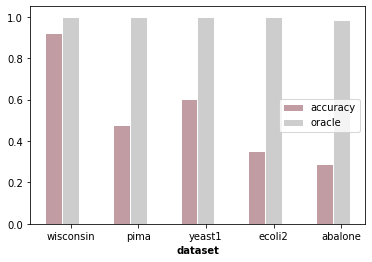

In [62]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = results_q2_df.accuracy.values
bars2 = results_q2_df.oracle.values

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, bars1, color='#C29CA3', width=barWidth, edgecolor='white', label='accuracy')
plt.bar(r2, bars2, color='#CDCDCD', width=barWidth, edgecolor='white', label='oracle')

 
# Add xticks on the middle of the group bars
plt.xlabel('dataset', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['wisconsin', 'pima', 'yeast1', 'ecoli2', 'abalone'])
 
# Create legend & Show graphic
plt.legend(loc='center right')
plt.show()
#plt.savefig(fname='./figs/q2_accuracies.png', dpi=300)
plt.close()    

In [63]:
# Storing the number of instances for each dataset:
sizes = []
for k in datasets:
    n = datasets[k]['train'][0].shape[0] + datasets[k]['test'][0].shape[0]
    sizes.append(n)

sizes

[336, 2308, 846, 1484, 214]

In [64]:
results_q2_df.mis_0_mean.values

array([nan, nan, nan, nan, nan])

In [65]:
results_q2_df.mis_0_mean.values/sizes

array([nan, nan, nan, nan, nan])

Plotting percentage of misclassified examples per class:

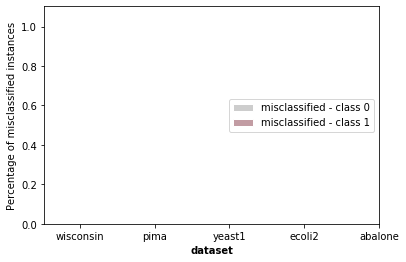

In [66]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = results_q2_df.n_hyper_mean.values
bars2 = results_q2_df.mis_0_mean.values/sizes
bars3 = results_q2_df.mis_1_mean.values/sizes

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
#plt.bar(r1, bars1, color='#C29CA3', width=barWidth, edgecolor='white', label='hyperplanes')
plt.bar(r2, bars2, color='#CDCDCD', width=barWidth, edgecolor='white', label='misclassified - class 0')
plt.bar(r3, bars3, color='#C29CA3', width=barWidth, edgecolor='white', label='misclassified - class 1')
 
# Add xticks on the middle of the group bars
plt.xlabel('dataset', fontweight='bold')
plt.ylabel('Percentage of misclassified instances')
plt.xticks([r + 1.5*barWidth for r in range(len(bars1))], ['wisconsin', 'pima', 'yeast1', 'ecoli2', 'abalone'])
 
# Create legend & Show graphic
plt.legend(loc='center right')
plt.show()
#plt.savefig(fname='./figs/q2_misclassified.png', dpi=300)
plt.close()    

Plotting number of hyperplanes used by SGH for each dataset:

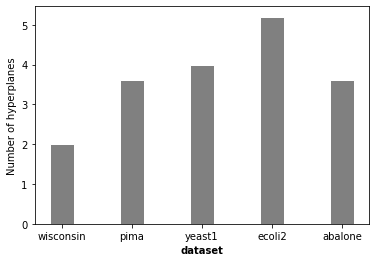

In [67]:
# set width of bar
barWidth = 0.35
 
# set height of bar
bars1 = results_q2_df.n_hyper_mean.values

# Set position of bar on X axis
r1 = np.arange(len(bars1))
 
# Make the plot
plt.bar(r1, bars1, color='grey', width=barWidth, edgecolor='white', label='hyperplanes')

# Add xticks on the middle of the group bars
plt.xlabel('dataset', fontweight='bold')
plt.ylabel('Number of hyperplanes')
plt.xticks([r for r in range(len(bars1))], ['wisconsin', 'pima', 'yeast1', 'ecoli2', 'abalone'])
 
# Create legend & Show graphic
#plt.legend(loc='center right')
plt.show()
#plt.savefig(fname='./figs/q2_hyperplanes.png', dpi=300)
plt.close()    